# Multispectral UAV Image Classification
## Data Preprocessing

 <!-- ## Table of Contents
1. [Load-utils](##Load-utils)
2. [Data Visualization](###Data-Visualization)
     -->

 Section
 ---
1. Load utils
2. Data Visualization
3. Load Data
4. Training and Validation data sets
5. Build classifier
      1. Random Forest
      2. SVM

## Load-utils

In [9]:
import rasterio
import numpy as np
import pandas as pd
import geopandas as gp
from rasterio.plot import reshape_as_image
import numpy as np
# import geopandas as gp
import matplotlib.pyplot as plt

### Data-Visualization
Basic data visualization

In [2]:
rgb = reshape_as_image((rasterio.open('raster/RGB.tif')).read())
dsm = (rasterio.open('raster/DSM_Clip.tif')).read(1)
dsm[dsm == -32767.0] = np.nan
reg = (rasterio.open('raster/REG3.tif')).read(1).astype('f4')
reg[reg == 0] = np.nan
nir = (rasterio.open('raster/NIR3.tif')).read(1).astype('f4')
nir[nir == 0] = np.nan

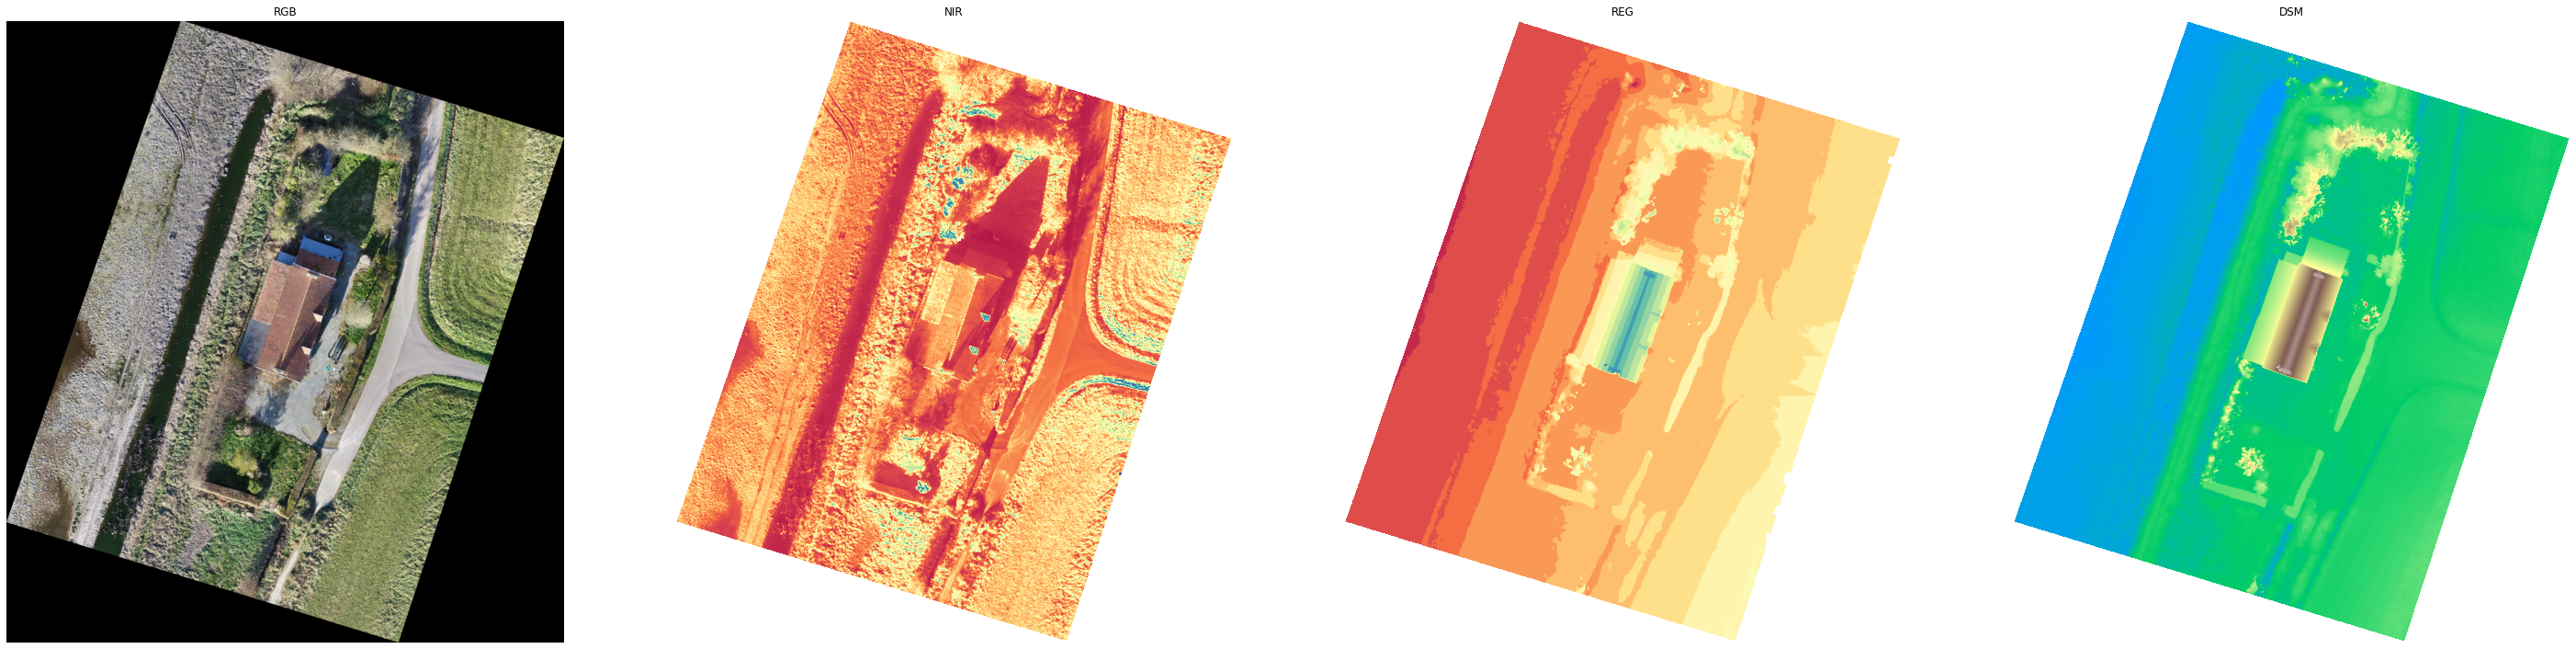

In [68]:
plt.figure(figsize=(50, 20))
plt.subplot(1, 4, 1)
plt.imshow(rgb)
plt.title('RGB')
plt.axis('off')
plt.subplot(1, 4, 2)
plt.imshow(nir, cmap='Spectral')
plt.title('NIR')
plt.axis('off')
plt.subplot(1, 4, 3)
plt.imshow(reg, cmap='Spectral')
plt.title('REG')
plt.axis('off')
plt.subplot(1, 4, 4)
plt.imshow(dsm, cmap='terrain')
plt.title('DSM')
plt.axis('off')
plt.show()

## Load data

In [3]:
# Data normalization
def normalize(data):
    """ Normalizes the data with min-max scaling."""
    data_min = np.nanmin(data)
    data_max = np.nanmax(data)
    data_norm = (data - data_min) / (data_max - data_min)
    return data_norm

In [4]:
def Load_raster(path):
    """This function read the dataset into the memory performs data normalizaton;
    it returns the data as a numpy array and the normlized image in (bands, row, col) structure"""
    src = rasterio.open(path)
    img = (src.read()).astype('f4')   # load our original input file bands to a numby array stack
    img[img == src.nodata] = np.nan
    # normalise img
    img_norm = normalize(img)
    src_profile = src.profile
    src_profile.update(dtype=rasterio.float64, nodata=np.nan)
    profile = src_profile  # the copy the profile of the original GeoTIFF input file
    with rasterio.io.MemoryFile() as memfile:
        with memfile.open(**profile) as dst:
            for i in range(0, src.count):
                dst.write(img_norm[i], i+1)
        dataset = memfile.open()
        return dataset#, img_norm

In [5]:
# read rgb data into memory
rgb_mem = Load_raster('raster/RGB.tif')
# read nir data into memory
nir_mem = Load_raster('raster/NIR3.tif')
# read reg data into memory
reg_mem = Load_raster('raster/REG3.tif')
# read dsm data into memory
dsm_mem = Load_raster('raster/DSM_Clip.tif')

In [6]:
dsm_src = rasterio.open('raster/DSM_Clip.tif')

# dsm_arr = dsm_src.read()
# pr = dsm_src.profile
# dsm_arr[dsm_arr == dsm_src.nodata] = np.nan
# dsm_norm = normalize(dsm_arr)

# We need to extract the nodata region, it will be need for the final visualization. Dsm is selected since all the bands hand the same nodata value/region.
rst = dsm_src.read(1, masked=True)

In [8]:
# with rasterio.io.MemoryFile() as memfile:
#         with memfile.open(**pr) as dst:
#             for i in range(0, dsm_src.count):
#                 dst.write(dsm_norm[i], i+1)
#         dsm_mem = memfile.open()

## Training and Validation data sets

The few sampling points were selceted traninng (45) and validation (35); for training and validation set 7 andd 5 points were selected respectively.

In [7]:
# class name
class_name = ['roof',  'water', 'road', 'grass', 'tree','sediment', 'bush'] # seven classes  

# training and validation paths
training_set_path = 'shapefile/training_set.shp'
validation_set_path = 'shapefile/validation_set.shp'

Training set shapefiles and its raster values as a Dataframe

In [10]:
train_points = gp.read_file(training_set_path)
coords = [(x,y) for x,y in zip(train_points.geometry.x, train_points.geometry.y)]

def get_raster_value(coords, raster, train_points, bands):#, composite_raster = 'rgb'):
    """ Returns the raster value of the given coordinates."""
    # get the raster value as float for the given coordinates
    train_points['value'] = [x for x in raster.sample(coords)]
    train_points[bands] = pd.DataFrame(train_points['value'].values.tolist(), index=train_points.index)
    train_points = train_points.drop(['value'], axis=1)
    train_points = train_points.drop(['geometry'], axis=1)
    # train_points.to_csv('%s.csv'%composite_raster)
    return train_points

# rgb bands
rgb_bands = ['red', 'green', 'blue']
rgb_train_points = get_raster_value(coords, rgb_mem, train_points, rgb_bands)#, 'rgb')
# nir bands
nir_train_points = get_raster_value(coords, nir_mem, train_points, 'nir')
# # reg bands
reg_train_points = get_raster_value(coords, reg_mem, train_points, 'reg')
# dsm bands
dsm_train_points = get_raster_value(coords, dsm_mem, train_points, 'dsm')

In [11]:
X  = train_points.drop(['class_code', 'value'], axis=1)
y = train_points['class_code']
X.head()

,id,geometry,red,green,blue,nir,reg,dsm
0,1,POINT (319895.549 6843677.891),0.992126,0.980315,0.897638,0.445036,0.400000,0.407411
1,2,POINT (319899.667 6843671.832),0.889764,0.708661,0.582677,0.452803,0.800000,0.759430
2,3,POINT (319904.095 6843671.016),0.992126,0.996063,0.870079,0.811625,0.666667,0.634352
3,4,POINT (319908.057 6843682.785),0.200787,0.342520,0.602362,0.052477,0.400000,0.334036
4,5,POINT (319890.461 6843664.568),0.149606,0.192913,0.346457,0.079958,0.400000,0.395814


Validation set

In [12]:
validation_points = gp.read_file(validation_set_path)
coords = [(x,y) for x,y in zip(validation_points.geometry.x, validation_points.geometry.y)]

# validation rgb bands
rgb_validation_points = get_raster_value(coords, rgb_mem, validation_points, rgb_bands)#, 'rgb')
# validation nir bands
nir_validation_points = get_raster_value(coords, nir_mem, validation_points, 'nir')
# validation reg bands
reg_validation_points = get_raster_value(coords, reg_mem, validation_points, 'reg')
# validation dsm bands
dsm_validation_points = get_raster_value(coords, dsm_mem, validation_points, 'dsm')

In [13]:
X_validation  = validation_points.drop(['class_code', 'value'], axis=1)
y_validation = validation_points['class_code']
X_validation.head()

,id,geometry,red,green,blue,nir,reg,dsm
0,1,POINT (319897.908 6843666.771),0.377953,0.287402,0.236220,0.371700,0.800000,0.762667
1,2,POINT (319902.470 6843668.292),0.311024,0.236220,0.248031,0.082339,0.666667,0.624987
2,3,POINT (319896.054 6843680.885),0.665354,0.566929,0.578740,0.321421,0.400000,0.395500
3,4,POINT (319906.509 6843677.511),0.472441,0.279528,0.295276,0.167714,0.600000,0.565524
4,5,POINT (319901.757 6843685.257),0.224409,0.381890,0.629921,0.053957,0.266667,0.322321


## Build classifiers

### Random Forest

Random forest model for training set

In [19]:
from sklearn.ensemble import RandomForestClassifier
#ignore warnings

import warnings
warnings.filterwarnings('ignore')

def train_model(X_train, y_train):
    """ Trains a random forest model."""
    model = RandomForestClassifier(n_estimators=100, oob_score=True, max_features='auto', random_state=42)
    model.fit(X_train, y_train)
    return model
#train model
# for RGB
xtrain_rgb = X[['red', 'green', 'blue']]
rgb_model = train_model(xtrain_rgb, y)
# for RGB + NIR
xtrain_rgb_nir = X[['red', 'green', 'blue', 'nir']]
rgb_nir_model = train_model(xtrain_rgb_nir, y)
# for RGB + REG
xtrain_rgb_reg = X[['red', 'green', 'blue', 'reg']]
rgb_reg_model = train_model(xtrain_rgb_reg, y)
# for RGB + DSM
xtrain_rgb_dsm = X[['red', 'green', 'blue', 'dsm']]
rgb_dsm_model = train_model(xtrain_rgb_dsm, y)
# for RGB + NIR + REG + DSM
xtrain_rgb_nir_reg_dsm = X[['red', 'green', 'blue', 'nir', 'reg', 'dsm']]
rgb_nir_reg_dsm_model = train_model(xtrain_rgb_nir_reg_dsm, y)

Random forest model predicted on the validation set

In [18]:
# accuracy metrics sklearn
from sklearn.metrics import accuracy_score#, precision_score, recall_score, f1_score
def validation_model(X_validation, y_validation, model):
    """ Validates the model."""
    y_pred = model.predict(X_validation)
    accuracy = accuracy_score(y_validation, y_pred)
    # print('Validation accuracy: %.2f' % accuracy)
    return accuracy

#rgb validation
xval_rgb = X_validation[['red', 'green', 'blue']]
print('RGB accuracy: %.2f' % validation_model(xval_rgb, y_validation, rgb_model))
#rgb + nir validation
# xval_rgb_nir = X_validation[['red', 'green', 'blue', 'nir']]
# print('RGB + NIR accuracy: %.2f' % validation_model(xval_rgb_nir, y_validation, rgb_nir_model))
# # #rgb + nir validation
# xval_rgb_reg = X_validation[['red', 'green', 'blue', 'reg']]
# print('RGB + REG accuracy: %.2f' % validation_model(xval_rgb_reg, y_validation, rgb_reg_model))
# # rgb + dsm validation
# xval_rgb_dsm = X_validation[['red', 'green', 'blue', 'dsm']]
# print('RGB + DSM accuracy: %.2f' % validation_model(xval_rgb_dsm, y_validation, rgb_dsm_model))
# # #rgb + nir + reg + dsm validation
xval_rgb_nir_reg_dsm = X_validation[['red', 'green', 'blue', 'nir', 'reg', 'dsm']]
print('RGB + NIR + REG + DSM accuracy: %.2f' % validation_model(xval_rgb_nir_reg_dsm, y_validation, rgb_nir_reg_dsm_model))

RGB accuracy: 0.29
RGB + NIR + REG + DSM accuracy: 0.60


Confusion matrix for training set and validation set

In [ ]:
print(classification_report(y_valid, y_pred, target_names=class_names))

RGB confusion matrix


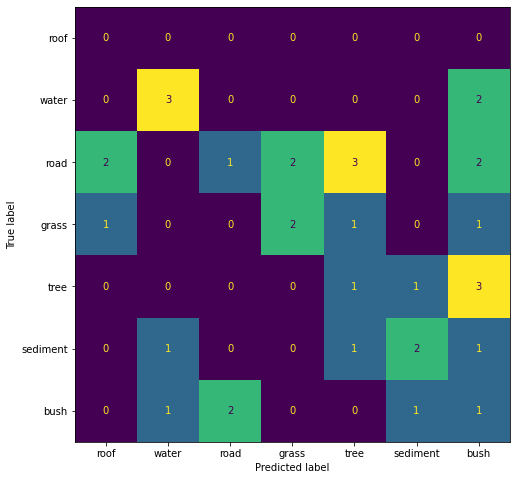

RGB + NIR confusion matrix


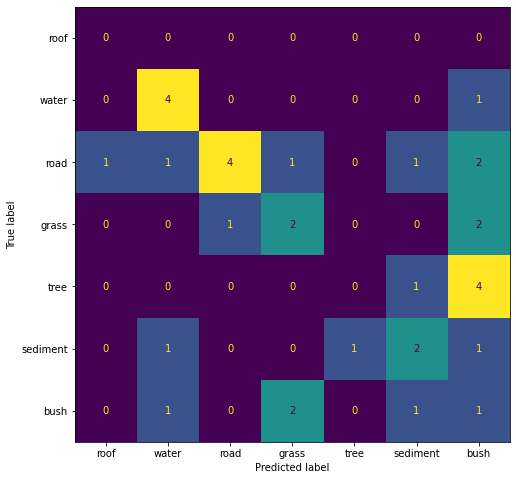

RGB + REG confusion matrix


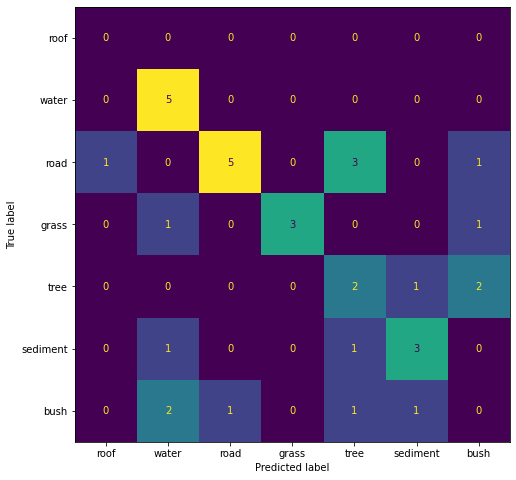

RGB + DSM confusion matrix


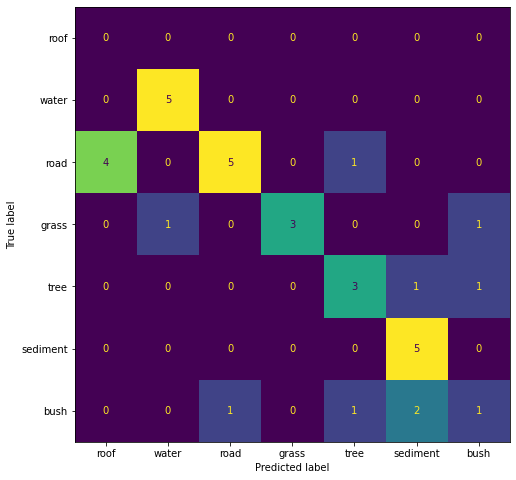

RGB + NIR + REG + DSM confusion matrix


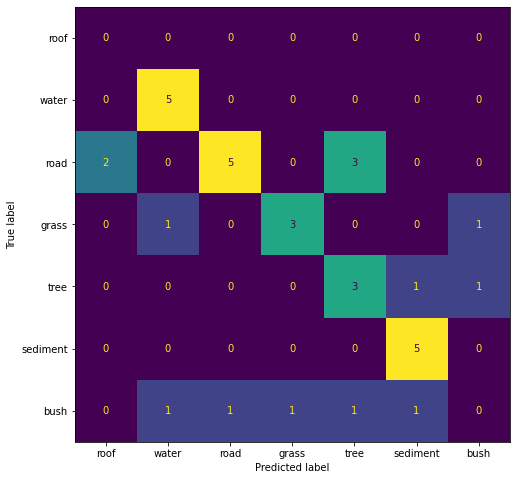

In [99]:
# build a confusion matrix for training and validation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

class_names = ['roof',  'water', 'road', 'grass', 'tree','sediment', 'bush']

def confusion_matrix_model(X_validation, y_validation, model):
    """" build and plot confuson matrix."""
    fig, ax = plt.subplots(figsize=(8, 8))
    plot_confusion_matrix(model, X_validation, y_validation, display_labels=class_names, ax=ax, colorbar= False)
    # print classification report
    # print(classification_report(y_validation, y_pred, target_names=class_names))
    plt.show()


#rgb confusion matrix
print('RGB confusion matrix')
confusion_matrix_model(xval_rgb, y_validation, rgb_model)
#rgb + nir confusion matrix
print('RGB + NIR confusion matrix')
confusion_matrix_model(xval_rgb_nir, y_validation, rgb_nir_model)
#rgb + reg confusion matrix
print('RGB + REG confusion matrix')
confusion_matrix_model(xval_rgb_reg, y_validation, rgb_reg_model)
#rgb + dsm confusion matrix
print('RGB + DSM confusion matrix')
confusion_matrix_model(xval_rgb_dsm, y_validation, rgb_dsm_model)
#rgb + nir + reg + dsm confusion matrix
print('RGB + NIR + REG + DSM confusion matrix')
confusion_matrix_model(xval_rgb_nir_reg_dsm, y_validation, rgb_nir_reg_dsm_model)
plt.show()

Plot feature importance

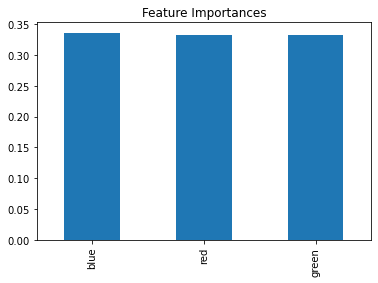

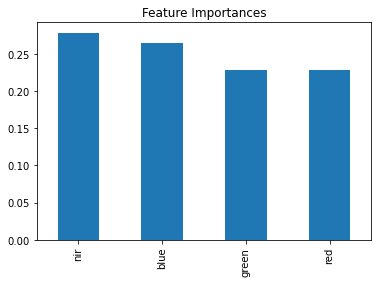

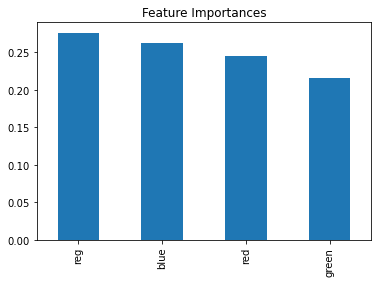

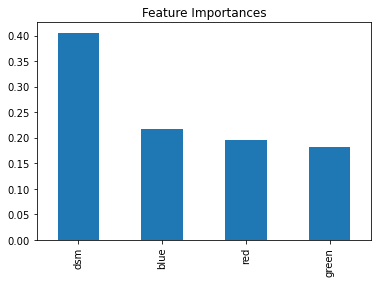

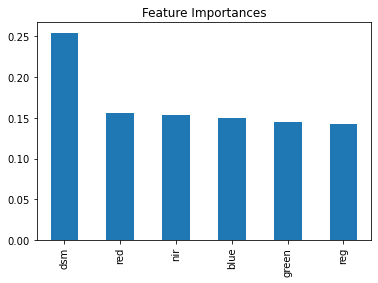

In [79]:
# plot the feature importance for the models

def plot_feature_importance(model, X_train):
    """ Plots the feature importance for the models."""
    # get the feature importances
    importances = model.feature_importances_
    # convert the importances into one-dimensional 1darray with corresponding df column names as axis labels
    f_importances = pd.Series(importances, X_train.columns)
    # sort the array in descending order of the importances
    f_importances.sort_values(ascending=False, inplace=True)
    # make the bar Plot from f_importances
    f_importances.plot(kind='bar', title='Feature Importances')
    plt.show()

# for rgb
plot_feature_importance(rgb_model, xtrain_rgb)

# for rgb + nir
plot_feature_importance(rgb_nir_model, xtrain_rgb_nir)

# for rgb + reg
plot_feature_importance(rgb_reg_model, xtrain_rgb_reg)

# for rgb + dsm
plot_feature_importance(rgb_dsm_model, xtrain_rgb_dsm)

# for rgb + nir + reg + dsm
plot_feature_importance(rgb_nir_reg_dsm_model, xtrain_rgb_nir_reg_dsm)

### Classification with models

In [16]:
# color dictionary for class_code 
colors = dict((
    # roof
    (0, (255,0,0,255)), 
    # water
    (1, (0,76,153,255)),
    # road
    (2, (160,160,160,255)),
    # sediment
    (3, (255,204,153,255)),
    # Tree
    (4, (0,128,0,255)),
    # Grass
    (5, (0,255,0,255)),
    # bush
    (6, (204,255,153,255))
))

# convert 0-255 values to 0-1 values
for k, v in colors.items():
    colors[k] = [x/255 for x in v]

# matplotlib colormap from color dictionary
index_colors = [colors[x] if x in colors else (0,0,0,1) for x in range(0,7)]
cmap = plt.matplotlib.colors.ListedColormap(index_colors, 'Classification', 7)

Classification on the image

In [17]:
# RGB + NIR + REG + DSM classification
#stack the rgb, nir and reg data into a single array
red, green, blue = rgb_mem.read()
nir = nir_mem.read(1)
reg = reg_mem.read(1)
dsm = dsm_mem.read(1)
rgbn_stack = np.dstack((red, green, blue, nir, reg, dsm))
rgbn_stack = np.nan_to_num(rgbn_stack)
rgbn_stack.shape

(9370, 8404, 6)

In [20]:
#reshape as ((rows*cols), bands)
reshape__d = rgbn_stack.reshape(-1, xval_rgb_nir_reg_dsm.shape[1])
band_reshaped = reshape_as_image(rgbn_stack)

# prediction on reshaped image using rgb model
class_rgb_nir_reg = rgb_nir_reg_dsm_model.predict(reshape__d)
# cl = class_rgb_nir_reg.reshape(rgbn_stack[:,:,0].shape)

# classified = np.ma.masked_array(cl, rst.mask)
# plt.figure(figsize=(15,15))
# plt.imshow(classified, cmap=cmap)
# plt.axis('off')
# plt.show()

In [21]:
class_rgb_nir_reg.shape

(78745480,)

In [105]:
rgb_dsm_stack = np.dstack((red, green, blue, dsm))
rgb_dsm_stack = np.nan_to_num(rgb_dsm_stack)
rgb_dsm_stack.shape

(9370, 8404, 4)

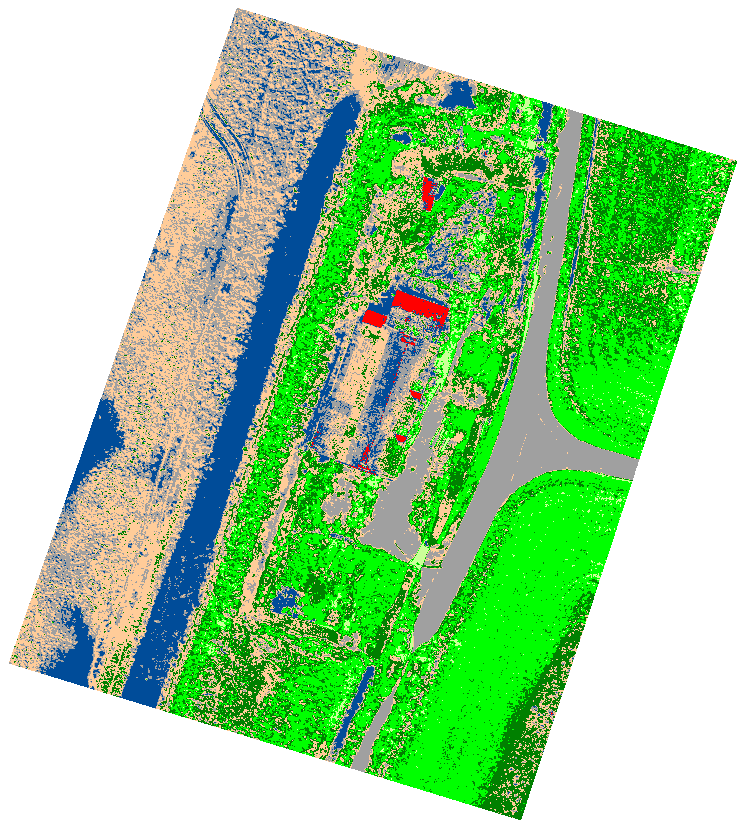

In [119]:
#reshape as ((rows*cols), bands)
reshape__rd = rgb_dsm_stack.reshape(-1, xval_rgb_dsm.shape[1])
band_reshaped_rd = reshape_as_image(rgb_dsm_stack)

# prediction on reshaped image using rgb model
class_rgb_dsm = rgb_dsm_model.predict(reshape__rd)
cl_rd = class_rgb_dsm.reshape(rgb_dsm_stack[:,:,0].shape)

classified_rd = np.ma.masked_array(cl_rd, rst.mask)
plt.figure(figsize=(15,15))
plt.imshow(classified_rd, cmap=cmap)
plt.axis('off')
plt.show()

### Support Vector Machine (SVM)

Build and Train SVM Classifier

In [108]:
from sklearn import svm

def train_svm_model(X_train, y_train):
    """ Trains the SVM model."""
    # train the model
    svm_model = svm.SVC()
    svm_model.fit(X_train, y_train)
    return svm_model

# train svm model
# for rgb
svm_rgb = train_svm_model(xtrain_rgb, y)
# for rgb + nir
svm_rgb_nir = train_svm_model(xtrain_rgb_nir, y)
# for rgb + nir + reg
svm_rgb_reg = train_svm_model(xtrain_rgb_reg, y)
# for rgb + dsm
svm_rgb_dsm = train_svm_model(xtrain_rgb_dsm, y)
# for rgb + nir + reg + dsm
svm_rgb_nir_reg_dsm = train_svm_model(xtrain_rgb_nir_reg_dsm, y)

In [111]:
# predict on validation set
def validation_svm_model(X_validation, y_validation, model):
    """ Predicts the class labels using the SVM model."""
    # predict the class labels
    y_pred = model.predict(X_validation)
    # calculate the accuracy
    accuracy = accuracy_score(y_validation, y_pred)
    return accuracy

# for rgb
print('RGB accuracy: %.2f' % validation_svm_model(xval_rgb, y_validation, svm_rgb))
# for rgb + nir
print('RGB + NIR accuracy: %.2f' % validation_svm_model(xval_rgb_nir, y_validation, svm_rgb_nir))
# for rgb + reg
print('RGB + REG accuracy: %.2f' % validation_svm_model(xval_rgb_reg, y_validation, svm_rgb_reg))
# for rgb + dsm
print('RGB + DSM accuracy: %.2f' % validation_svm_model(xval_rgb_dsm, y_validation, svm_rgb_dsm))
# for rgb + nir + reg + dsm
print('RGB + NIR + REG + DSM accuracy: %.2f' % validation_svm_model(xval_rgb_nir_reg_dsm, y_validation, svm_rgb_nir_reg_dsm))

RGB accuracy: 0.23
RGB + NIR accuracy: 0.23
RGB + REG accuracy: 0.40
RGB + DSM accuracy: 0.37
RGB + NIR + REG + DSM accuracy: 0.60


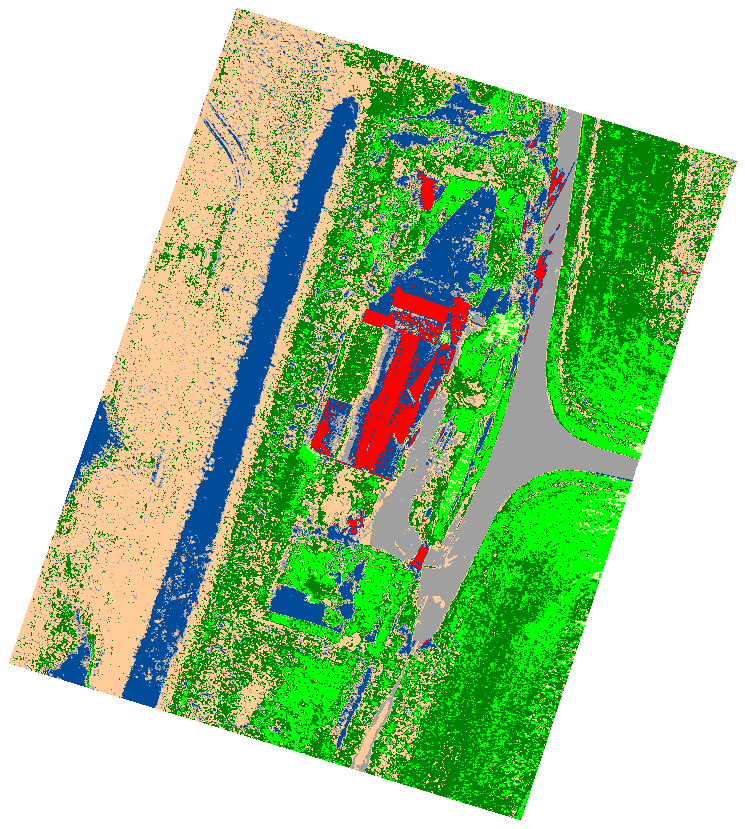

In [120]:
# prediction on reshaped image using rgb model
svm_class_rgb_nir_reg_dsm = svm_rgb_nir_reg_dsm.predict(reshape__d)
svm_cl = svm_class_rgb_nir_reg_dsm.reshape(rgbn_stack[:,:,0].shape)

svm_classified = np.ma.masked_array(svm_cl, rst.mask)
plt.figure(figsize=(15,15))
plt.imshow(svm_classified, cmap=cmap)
plt.axis('off')
plt.show()

In [122]:
# second rank svm model
svm_sec_stack = np.dstack((red, green, blue, reg))
svm_sec_stack = np.nan_to_num(svm_sec_stack)
# svm_sec_stack.shape

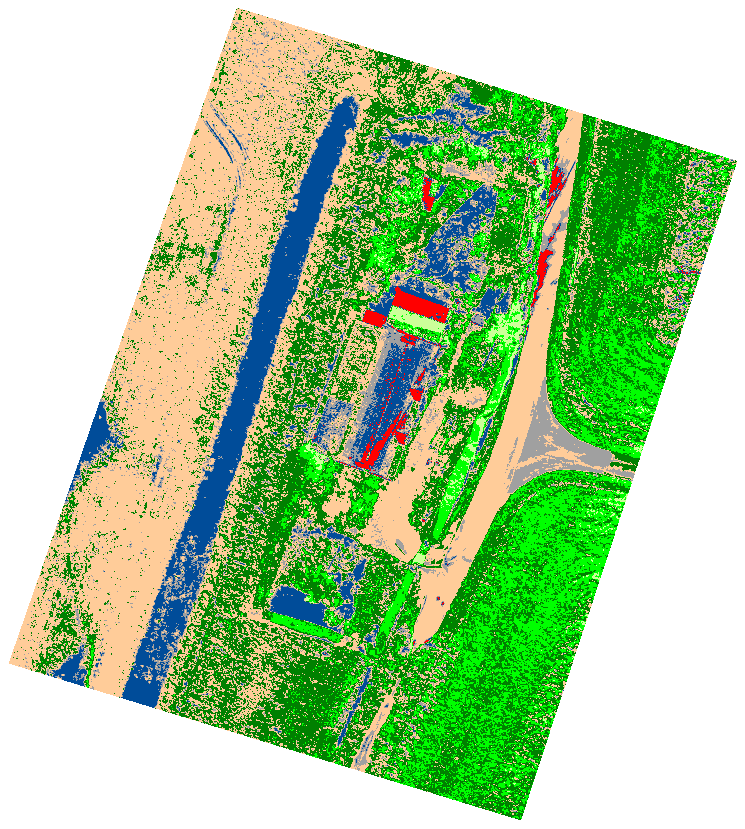

In [123]:
#reshape as ((rows*cols), bands)
svm_reshape__rd = svm_sec_stack.reshape(-1, xval_rgb_reg.shape[1])
svm_band_reshaped_rd = reshape_as_image(svm_sec_stack)

# prediction on reshaped image using rgb model
svm_class_rgb_dsm = svm_rgb_dsm.predict(svm_reshape__rd)
svm_cl_rd = svm_class_rgb_dsm.reshape(svm_sec_stack[:,:,0].shape)

svm_classified_rd = np.ma.masked_array(svm_cl_rd, rst.mask)
plt.figure(figsize=(15,15))
plt.imshow(svm_classified_rd, cmap=cmap)
plt.axis('off')
plt.show()